In [11]:
import joblib 
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
if 'src' in os.getcwd() or 'results' in os.getcwd():
    os.chdir('..')
    print(os.getcwd())
if 'src' not in os.getcwd():
    os.chdir('src')

from experiments_helpers import ExperimentResults

if 'src' in os.getcwd() or 'results' in os.getcwd():
    os.chdir('..')
    print(os.getcwd())

folder = 'results_experiment_corr'
name = 'mlp-torch-fico-robx-TwoSamplesOneDatasetExperimentData-config_a060.yml_0'

es_base: ExperimentResults = ExperimentResults.load_results_from_file(f'{folder}/{name}.joblib')

es_base.pretty_print_robust_vs_base()

/home/ignacy/research/robust-cf
ExperimentResults with 30 metrics and 0 artifacts.
############################## Metrics ##############################
------------------------- Base metrics -------------------------
validity: 1.00 (std: 0.00)
proximityL1: 1.83 (std: 1.27)
proximityL2: 0.47 (std: 0.33)
lof: -1.33 (std: 0.27)
cf_counterfactual_stability: 0.40 (std: 0.03)
dpow: 0.44 (std: 0.13)
plausibility: 0.80 (std: 0.20)
generation_time: 0.01 (std: 0.01)
------------------------- Base metrics 2 -------------------------
validity_2: 0.39 (std: 0.49)
proximityL1_2: 1.83 (std: 1.27)
proximityL2_2: 0.47 (std: 0.33)
lof_2: -1.41 (std: 0.30)
cf_counterfactual_stability_2: 0.49 (std: 0.10)
dpow_2: 0.54 (std: 0.16)
plausibility_2: 0.81 (std: 0.20)
------------------------- Robust metrics -------------------------
robust_validity: 1.00 (std: 0.00)
robust_proximityL1: 2.35 (std: 0.84)
robust_proximityL2: 0.67 (std: 0.21)
robust_lof: -1.13 (std: 0.12)
robust_cf_counterfactual_stability: 0.61 (

In [2]:
es_base.get_results_as_pandas()

,validity,proximityL1,proximityL2,lof,cf_counterfactual_stability,dpow,plausibility,validity_2,proximityL1_2,proximityL2_2,...,robust_dpow,robust_plausibility,robust_validity_2,robust_proximityL1_2,robust_proximityL2_2,robust_lof_2,robust_cf_counterfactual_stability_2,robust_dpow_2,robust_plausibility_2,robust_generation_time
0,1,1.691864,0.411035,-1.223952,0.421192,0.466667,0.700050,1,1.691864,0.411035,...,0.466667,0.700050,1,1.691864,0.411035,-1.332822,0.411697,0.600000,0.692578,0.021031
1,1,2.683476,0.677376,-1.270927,0.489777,0.466667,0.670356,0,2.683476,0.677376,...,0.466667,0.679943,0,2.770568,0.704533,-1.332912,0.396855,0.666667,0.674851,0.137569
2,1,0.976842,0.253577,-1.471964,0.388567,0.400000,1.026190,0,0.976842,0.253577,...,0.400000,0.982598,0,1.314462,0.341007,-1.528799,0.424666,0.666667,0.955860,0.217880
3,1,1.380744,0.347940,-1.113969,0.364691,0.533333,0.839914,1,1.380744,0.347940,...,0.533333,0.829929,1,1.372426,0.350508,-1.187250,0.425257,0.466667,0.895355,0.195726
4,1,6.718986,1.822267,-2.840202,0.493651,0.400000,1.775454,0,6.718986,1.822267,...,0.600000,2.057792,1,8.042040,2.294304,-3.045791,0.624763,0.266667,2.061054,0.908189
5,1,1.968389,0.510630,-1.179672,0.393250,0.333333,0.657760,1,1.968389,0.510630,...,0.400000,0.710043,1,2.595781,0.657183,-1.384821,0.668932,0.533333,0.727487,0.458769
6,1,1.612190,0.419694,-1.235833,0.398454,0.333333,0.682102,0,1.612190,0.419694,...,0.333333,0.682102,0,1.612190,0.419694,-1.281585,0.537810,0.800000,0.673029,0.059213
7,1,1.383285,0.399041,-1.600167,0.421976,0.600000,1.043584,0,1.383285,0.399041,...,0.600000,1.043584,0,1.383285,0.399041,-1.714351,0.635522,0.466667,1.111057,0.046418
8,1,1.385781,0.336796,-1.091156,0.370537,0.466667,0.601887,0,1.385781,0.336796,...,0.466667,0.602864,0,1.421214,0.344863,-1.144995,0.485642,0.600000,0.583328,0.139044
9,1,1.158585,0.302691,-2.018709,0.435398,0.600000,1.633667,1,1.158585,0.302691,...,0.600000,1.633667,1,1.158585,0.302691,-2.352886,0.474127,0.533333,1.730221,0.075443


In [3]:
res = es_base.get_results_as_pandas()
res = res.dropna() #TODO investigate what causes nulls 
res = res[res['robust_validity'] > 0] #TODO fix so robust cf is always valid for model 1
cols = [x for x in res.columns if 'prox' in x]
res[cols].mean()

proximityL1             1.733080
proximityL2             0.454201
proximityL1_2           1.733080
proximityL2_2           0.454201
robust_proximityL1      1.917480
robust_proximityL2      0.508804
robust_proximityL1_2    1.917480
robust_proximityL2_2    0.508804
dtype: float64

In [6]:
name = 'mlp-torch-fico-statrob-TwoSamplesOneDatasetExperimentData-config_a0'

robs = []
robs_std = []
results_dfs = []

threshs = np.array([60])
for i, a in enumerate(threshs):
    f = f'{folder}/{name}{a}.yml_0.joblib'
    print(f)
    er = ExperimentResults.load_results_from_file(f)
    res = er.get_results_as_pandas()
    res = res.dropna() #TODO investigate what causes nulls 
    res = res[res['robust_validity'] > 0] #TODO fix so robust cf is always valid for model 1
    cols = [x for x in res.columns if 'validity' in x]
    means = res[cols].mean().to_numpy()
    stds = res[cols].std().to_numpy()
    robs.append(means)
    robs_std.append(stds)
    results_dfs.append(res)

df_stdev = pd.DataFrame(robs_std, columns=cols)
df_stdev.columns = ['validity_orig_1', 'validity_orig_2', 'validity_statrob_1', 'validity_statrob_2']
df_stdev['alpha-Rob'] = [float(f'0.{t}') for t in threshs] 
print('stddevs:', df_stdev.round(3))
df = pd.DataFrame(robs, columns=cols).round(3)
df.columns = ['validity_orig_1', 'validity_orig_2', 'validity_statrob_1', 'validity_statrob_2']
df['alpha-Rob'] = [float(f'0.{t}') for t in threshs] 
df

results_experiment_corr/mlp-torch-fico-statrob-TwoSamplesOneDatasetExperimentData-config_a060.yml_0.joblib
stddevs:    validity_orig_1  validity_orig_2  validity_statrob_1  validity_statrob_2  \
0              0.0            0.505                 0.0               0.488   

   alpha-Rob  
0        0.6  


,validity_orig_1,validity_orig_2,validity_statrob_1,validity_statrob_2,alpha-Rob
0,1.0,0.49,1.0,0.627,0.6


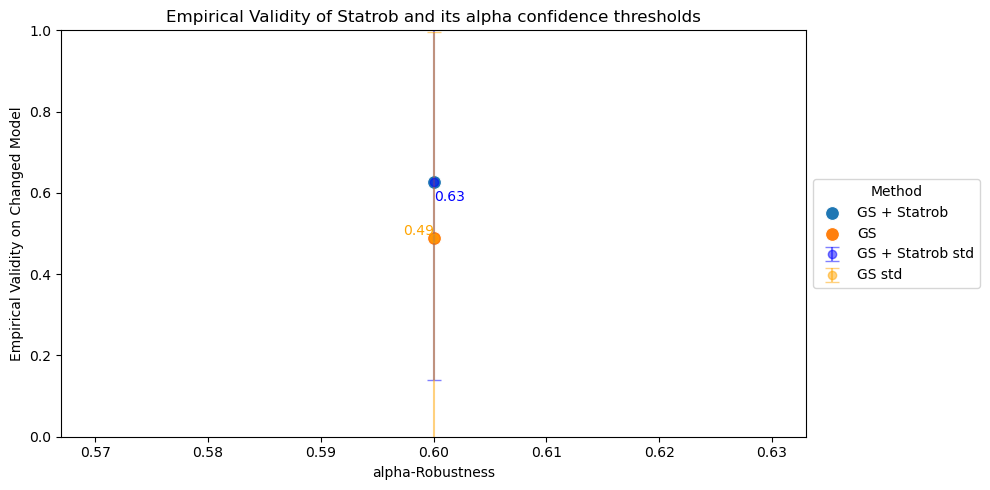

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
method = 'Statrob' if 'statrob' in name else 'Robx'

sns.scatterplot(data=df, x='alpha-Rob', y='validity_statrob_2', s=100, legend=False, label=f'GS + {method}')
#Add error bars
plt.errorbar(df['alpha-Rob'], df['validity_statrob_2'], yerr=df_stdev['validity_statrob_2'], 
             fmt='o', color='blue', capsize=5, alpha=0.5, label=f'GS + {method} std')

sns.scatterplot(data=df, x='alpha-Rob', y='validity_orig_2', s=100, legend=False, label='GS')
plt.errorbar(df['alpha-Rob'], df['validity_orig_2'], yerr=df_stdev['validity_orig_2'],
                fmt='o', color='orange', capsize=5, alpha=0.5, label='GS std')


plt.title(f'Empirical Validity of {method} and its alpha confidence thresholds')
plt.xlabel('alpha-Robustness')
plt.ylabel('Empirical Validity on Changed Model')
# Set y-limit to 1
plt.ylim(0, 1)

#Plot the numbers next to the points
for i, row in df.iterrows():
    plt.text(row['alpha-Rob'], row['validity_statrob_2'] - 0.02, f'{row["validity_statrob_2"]:.2f}', ha='left', va='top', color='blue')
    plt.text(row['alpha-Rob'], row['validity_orig_2'], f'{row["validity_orig_2"]:.2f}', ha='right', va='bottom', color='orange')


# Move the legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Method')
plt.savefig(f'{folder}/{name}_val_rob_corr.png')

plt.tight_layout()
plt.show()

In [8]:
table = df.drop('alpha-Rob', axis=1).iloc[3].to_frame().round(3)
# table.index = ['original_1', 'original_2', 'statrob_1', 'statrob_2']
table.columns = ['Validity']
table['StdDev'] = df_stdev.iloc[3].to_numpy().round(3)
table['model'] = ['original', 'changed', 'original', 'changed']
table['Method'] = ['GrowingSpheres', 'GrowingSpheres', 'GrowingSpheres + Statrobxplus(0.9-Rob)', 'GrowingSpheres + Statrobxplus(0.9-Rob)']



# Plotting the bar plot
sns.catplot(
    data=table, kind="bar",
    y="Validity", x="Method", hue="model",
    palette="dark", alpha=.6, height=6, legend=True, legend_out=False, aspect=2
)

# Adding error bars based on StdDev
for i, (validity, std_dev) in enumerate(zip(table['Validity'], table['StdDev'])):
    if i % 2 == 1:
        plt.errorbar(i / 2 - 0.3 , validity, yerr=std_dev, fmt='none', ecolor='black', capsize=5, alpha=0.3)

# Adding numbers on top of bars
ax = plt.gca()
for cont in ax.containers[:2]:
    for bar in cont:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Adjusting legend position
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')

plt.title('Validity of counterfactuals on the original and changed model. \nExperiment: Same data, same model with different seed')
plt.tight_layout()
plt.savefig(f'{folder}/{name}_barplot.png')
plt.show()


print(table)

IndexError: single positional indexer is out-of-bounds

In [ ]:
name = 'torch-fico-robx-var01-config0'

robs = []
robs_std = []
notna_count = []

threshs = np.array([6,7,8,9])
for i, a in enumerate(threshs):
    f = f'{folder}/{name}{a}_0.joblib'
    print(f)
    er = ExperimentResults.load_results_from_file(f)
    res = er.get_results_as_pandas()
    # res = res.dropna() #TODO investigate what causes nulls 
    # res = res[res['robust_validity'] > 0] #TODO fix so robust cf is always valid for model 1
    cols = [x for x in res.columns if 'validity' in x]
    means = res[cols].mean().to_numpy()
    stds = res[cols].std().to_numpy()
    robs.append(means)
    robs_std.append(stds)
    
    notna_count.append(res[cols].notna().sum().to_numpy())

df_stdev = pd.DataFrame(robs_std, columns=cols)
print('stddevs:', df_stdev.round(3))
df = pd.DataFrame(robs, columns=cols).round(3)
df.columns = ['validity_orig_1', 'validity_orig_2', 'validity_statrob_1', 'validity_statrob_2']
df['alpha-Rob'] = threshs / 10
df

results_bench/torch-fico-robx-var01-config06_0.joblib
results_bench/torch-fico-robx-var01-config07_0.joblib
results_bench/torch-fico-robx-var01-config08_0.joblib
results_bench/torch-fico-robx-var01-config09_0.joblib
stddevs:    validity  validity_2  robust_validity  robust_validity_2
0       0.0       0.447              0.0                0.0
1       0.0       0.427              0.0                0.0
2       0.0       0.454              0.0                0.0
3       0.0       0.418              0.0                0.0


,validity_orig_1,validity_orig_2,validity_statrob_1,validity_statrob_2,alpha-Rob
0,1.0,0.726,1.0,1.0,0.6
1,1.0,0.761,1.0,1.0,0.7
2,1.0,0.711,1.0,1.0,0.8
3,1.0,0.776,1.0,1.0,0.9


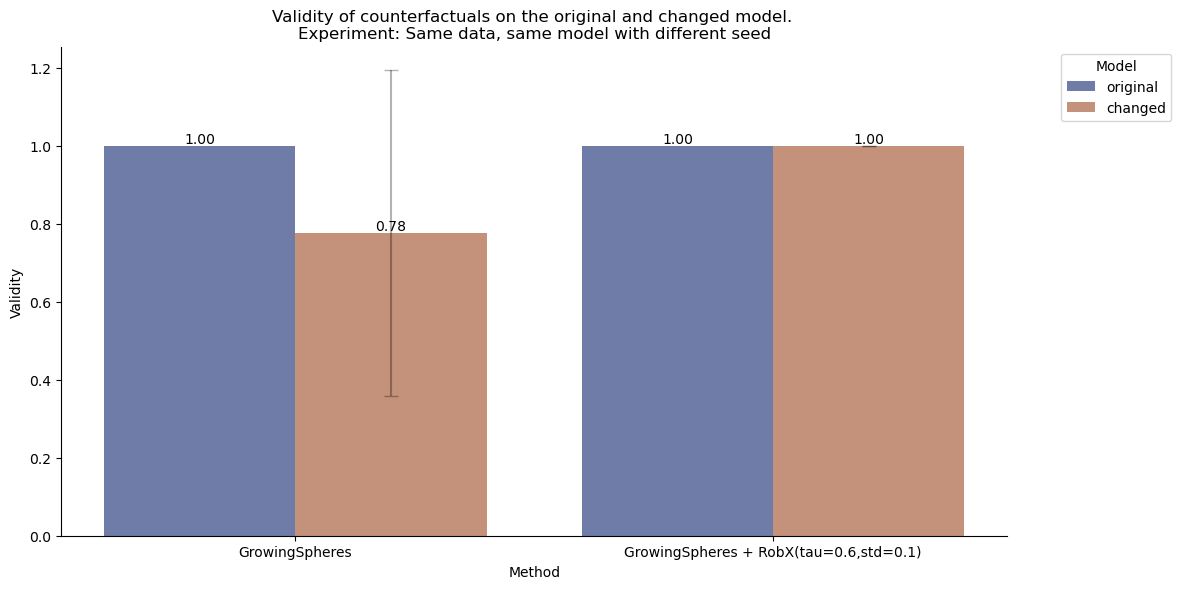

                    Validity  StdDev     model  \
validity_orig_1        1.000   0.000  original   
validity_orig_2        0.776   0.418   changed   
validity_statrob_1     1.000   0.000  original   
validity_statrob_2     1.000   0.000   changed   

                                                    Method  
validity_orig_1                             GrowingSpheres  
validity_orig_2                             GrowingSpheres  
validity_statrob_1  GrowingSpheres + RobX(tau=0.6,std=0.1)  
validity_statrob_2  GrowingSpheres + RobX(tau=0.6,std=0.1)  


In [ ]:
table = df.drop('alpha-Rob', axis=1).iloc[3].to_frame().round(3)
# table.index = ['original_1', 'original_2', 'statrob_1', 'statrob_2']
table.columns = ['Validity']
table['StdDev'] = df_stdev.iloc[3].to_numpy().round(3)
table['model'] = ['original', 'changed', 'original', 'changed']
table['Method'] = ['GrowingSpheres', 'GrowingSpheres', 'GrowingSpheres + RobX(tau=0.6,std=0.1)', 'GrowingSpheres + RobX(tau=0.6,std=0.1)']



# Plotting the bar plot
sns.catplot(
    data=table, kind="bar",
    y="Validity", x="Method", hue="model",
    palette="dark", alpha=.6, height=6, legend=True, legend_out=False, aspect=2
)

# Adding error bars based on StdDev
for i, (validity, std_dev) in enumerate(zip(table['Validity'], table['StdDev'])):
    if i % 2 == 1:
        plt.errorbar(i / 2 - 0.3 , validity, yerr=std_dev, fmt='none', ecolor='black', capsize=5, alpha=0.3)

# Adding numbers on top of bars
ax = plt.gca()
for cont in ax.containers[:2]:
    for bar in cont:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Adjusting legend position
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')

plt.title('Validity of counterfactuals on the original and changed model. \nExperiment: Same data, same model with different seed')
plt.tight_layout()
plt.savefig(f'{folder}/{name}_barplot.png')
plt.show()


print(table)

In [ ]:
notna_df = pd.DataFrame(notna_count, columns=cols)
notna_df.index = ['tau=0.6', 'tau=0.7', 'tau=0.8', 'tau=0.9']
notna_df.columns = ['validity_base_original', 'validity_base_changed', 'validity_robx_original', 'validity_robx_changed']
print('How many instances were correctly returned by the explainer? For how many instances was RobX able to find a valid CF?')
notna_df

How many instances were correctly returned by the explainer? For how many instances was RobX able to find a valid CF?


,validity_base_original,validity_base_changed,validity_robx_original,validity_robx_changed
tau=0.6,201,201,201,201
tau=0.7,201,201,201,201
tau=0.8,201,201,64,64
tau=0.9,201,201,62,62
